**OBJECTIVE:** Introduce the notion of pre-trained models using HuggingFace

**AUTHOR:** [@jonjoncardoso](https://github.com/jonjoncardoso)

**LAST UPDATED:** 25/02/2022

# Imports

Import libraries and initialise variables that will be re-used throughout this notebook

In [1]:
import os
import wget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

import dask.dataframe as dd

from plotnine import * # This package emulates ggplot2 syntax, an R package, in python

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

# Constants

In [2]:
map_dtypes = {'Unnamed: 0': str, 
              'id': str, 
              'domain': str, 
              'type': 'category', 
              'url': str, 
              'content': str, 
              'scraped_at': str, 
              'inserted_at': str,
              'updated_at': str, 
              'title': str, 
              'authors': str, 
              'keywords': str, 
              'meta_keywords': str,
              'meta_description': str, 
              'tags': str, 
              'summary': str, 
              'source': str}

categorical_types = ['rumor', 
                     'hate', 
                     'unreliable', 
                     'conspiracy', 
                     'clickbait', 
                     'satire', 
                     'fake', 
                     'reliable', 
                     'bias', 
                     'political', 
                     'junksci', 
                     np.nan, 
                     'unknown']

DATASET_PATH = "../data/data/news_sample.csv"

# Data Input

We are using a sample of [several27/FakeNewsCorpus](https://github.com/several27/FakeNewsCorpus).

In [7]:
df = pd.read_csv(DATASET_PATH,
                 dtype=map_dtypes,
                 parse_dates=["scraped_at", "inserted_at", "updated_at"])

In [8]:
sample_df = df.sample(n=10000, random_state=42)
sample_df["type"] = pd.Categorical(sample_df["type"], 
                                   categories=reversed(df["type"].value_counts(dropna=True).index.tolist()), 
                                   ordered=True)

# Initial Exploration of the Dataset

Let us look at a sample of this dataset first:

In [9]:
def print_document(idx, df=sample_df):
    print("<<TITLE:>> {}".format(df.iloc[idx]["title"]))
    print(f"<<ID:>> {idx}")
    print(f"<<SCRAPED_AT:>> {df.iloc[idx]['scraped_at']}")
    print(f"<<TYPE:>> {df.iloc[idx]['type']}")
    print(f"<<DOMAIN:>> {df.iloc[idx]['domain']}")

    print("-"*40)
    print("\n<<START OF CONTENT>>\n")
    print(df.iloc[idx]["content"])
    print("\n\n")
    print("\n<<END OF CONTENT>>\n")
    print("-"*40)

In [10]:
sample_df.index = range(10000)

In [14]:
# print_document(2007, sample_df)
# print_document(5305, sample_df)

## What are the columns?

In [12]:
idx = 2007

sample_df.iloc[idx:idx+1].set_index(["type", "domain", "title"])

,,,id,url,content,scraped_at,inserted_at,updated_at,authors,keywords,meta_keywords,meta_description,tags,summary,source
type,domain,title,,,,,,,,,,,,,
junksci,naturalnewsblogs.com,Is There A Safe Weight Loss Detox Diet?,2108807,https://www.naturalnewsblogs.com/is-there-a-sa...,Many people shy away from even trying detox di...,2017-11-10T11:18:44.524042,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,"Sandy Halliday, Sexy-Author-Bio, Background, F...",NaN,[''],Many weight loss detox diets call for severe d...,"detox diet, weight loss, weight loss detox die...",NaN,NaN


## What type of news do we have?

In [13]:
summary_df = \
    pd.concat([sample_df["type"].value_counts(dropna=False),
               sample_df["type"].value_counts(dropna=False).apply(lambda x: pd.Series({"pctg":  (x/sample_df.shape[0])}))],
              axis=1)

summary_df.reset_index(inplace=True)
summary_df.columns = ["type", "count", "pctg"]
summary_df["type"] = pd.Categorical(summary_df["type"], 
                                    categories=reversed(df["type"].value_counts(dropna=True).index.tolist()), 
                                    ordered=True)
summary_df

,type,count,pctg
0,political,2459,0.2459
1,bias,1728,0.1728
2,fake,1386,0.1386
3,conspiracy,1233,0.1233
4,rumor,747,0.0747
5,NaN,581,0.0581
6,unknown,545,0.0545
7,unreliable,442,0.0442
8,clickbait,370,0.0370
9,junksci,169,0.0169


In [15]:
aux_df = sample_df.groupby(["type"])["domain"].unique().to_frame()
aux_df.reset_index(inplace=True)
aux_df["domain"] = aux_df["domain"].apply(lambda x: " , ".join(x))
aux_df.set_index(["type", "domain"])

,
type,domain
reliable,"nutritionfacts.org , www.cbsnews.com , christianpost.com , consortiumnews.com , www.yahoo.com , abcnews.go.com , indianexpress.com , www.legacy.com , www.reuters.com , www.latimes.com , www.chron.com , www.nytimes.com"
hate,"barnesreview.org , nationalvanguard.org , themuslimissue.wordpress.com , amren.com , returnofkings.com , therightstuff.biz , davidduke.com , drrichswier.com , ihr.org , barenakedislam.com , darkmoon.me"
satire,"us.blastingnews.com , worldnewsdailyreport.com , politicops.com , thespoof.com , burrardstreetjournal.com , politicot.com , thehardtimes.net , theonion.com , thedailymash.co.uk , themideastbeast.com , fridaymash.com , thedailywtf.com , theineptowl.com , dailysquib.co.uk , actualidadpanamericana.com , disclose.tv , ncscooper.com , chronicle.su , clickhole.com , humortimes.com , waterfordwhispersnews.com , celebtricity.com , betootaadvocate.com , diversitychronicle.wordpress.com , christwire.org"
junksci,"naturalnews.com , naturalnewsblogs.com , healthimpactnews.com , ancient-code.com , icr.org , collective-evolution.com , collectivelyconscious.net , galacticconnection.com , ewao.com , realfarmacy.com , in5d.com , thetruthaboutcancer.com , wakingtimes.com , naturalblaze.com , revolutions2040.com , foodbabe.com"
clickbait,"twitchy.com , liberalamerica.org , lifesitenews.com , lifezette.com , politicususa.com , breaking911.com , bluenationreview.com , elitereaders.com , yournewswire.com , nymeta.co , remedydaily.com"
unreliable,"theduran.com , usdefensewatch.com , wikileaks.org , morningnewsusa.com , morningledger.com , coasttocoastam.com , anonhq.com , libertynews.com , allnewspipeline.com , veteransnewsnow.com , cnnnext.com , theantimedia.org , shareblue.com , wikileaks.com , ahtribune.com , breakpoint.org , ifyouonlynews.com , thefreethoughtproject.com , weaselzippers.us , conservativeoutfitters.com"
unknown,"opednews.com , shadowproof.com , thepeoplescube.com , teapartytribune.com , powerlineblog.com , thepostemail.com , tyronetribulations.com , theconservativetreehouse.com , therussophile.org , thesaker.is , thesleuthjournal.com , readynutrition.com , strategic-culture.org , surenews.com , truthingold.com , thegoldwater.com , policestateusa.com , unionleader.com , rbth.com , flyheight.com , toprightnews.com , kingworldnews.com , theorganicprepper.ca , therebel.media , tribunist.com , undergroundhealth.com , shtfplan.com , tribuneherald.net , shiftfrequency.com , russia-direct.org , sott.net , thenewinquiry.com , trueeconomics.blogspot.com , thrivemovement.com , southfront.org , theopenscroll.blogspot.com , randpaulreview.com , policyreview.info"
rumor,"express.co.uk , americantoday.news"
conspiracy,"abovetopsecret.com , activistpost.com , fellowshipoftheminds.com , wikispooks.com , zerohedge.com , awarenessact.com , thelibertybeacon.com , 21stcenturywire.com , infowars.com , rense.com , prisonplanet.com , thedailysheeple.com , truthbroadcastnetwork.com , pamelageller.com , conservativerefocus.com , shoebat.com , thephaser.com , infiniteunknown.net , davidwolfe.com , humansarefree.com , newstarget.com , counterpsyops.com , neonnettle.com , freedomoutpost.com , endoftheamericandream.com , theeventchronicle.com , eyeopening.info , jihadwatch.org , intellihub.com , corbettreport.com , theeconomiccollapseblog.com , investmentresearchdynamics.com , familysecuritymatters.org , whatreallyhappened.com , politicalblindspot.com , americanfreepress.net , dcclothesline.com , canadafreepress.com , educate-yourself.org , themindunleashed.com , blackgenocide.org , whatdoesitmean.com , whowhatwhy.org , thepoliticalinsider.com , jesus-is-savior.com , gaia.com , greanvillepost.com , theforbiddenknowledge.com , secretsofthefed.com , henrymakow.com , nodisinfo.com"


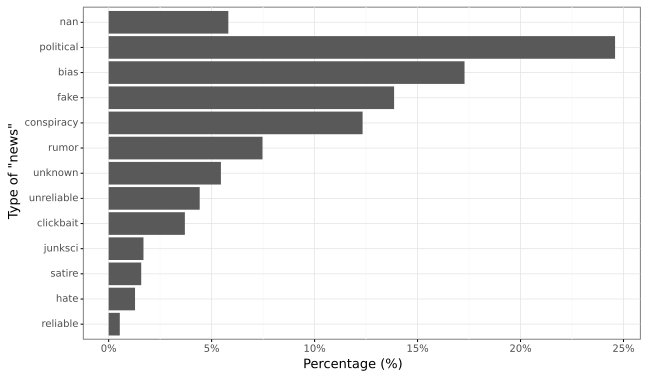

<ggplot: (8772115979524)>

In [16]:
from mizani.formatters import percent_format

g = (ggplot(summary_df, aes(x="type", y="pctg")) + 
     geom_col() +  
     theme_bw() + 
     theme(figure_size=(10, 6),
           axis_text=element_text(size=10),
           axis_title=element_text(size=13)) + 
     coord_flip() +
     scale_y_continuous(name="Percentage (%)", labels=percent_format()) +
     scale_x_discrete(name="Type of \"news\""))

g

### Junk Science 

> Sources that promote pseudoscience, metaphysics, naturalistic fallacies, and other scientifically dubious claims.

**Junk science sounds fun!** Let us have a look at the titles of these so called news.

In [19]:
sample_df[sample_df["type"] == "junksci"].set_index(["domain","title"])[[]].sample(n=10, random_state=78)

Empty DataFrame
Columns: []
Index: [(naturalnews.com, Natural Cold Remedies), (naturalnews.com, Mainstream press news, articles and information:), (ancient-code.com, Authentic footage Archives), (ancient-code.com, Secret tunnel Archives), (naturalnews.com, Acupuncture shown to boost fertility better than medication), (naturalnews.com, Alive New York news, articles and information:), (naturalnews.com, Wall Street investors news, articles and information:), (naturalnews.com, The Illinois lottery just imploded, declaring it can no longer pay large winnings), (naturalnews.com, Healthy diets news, articles and information:), (naturalnews.com, indoor gardening)]

### Fake

> Sources that entirely fabricate information, disseminate deceptive content, or grossly distort actual news reports

In [20]:
sample_df[sample_df["type"] == "fake"].set_index(["domain","title"])[[]].sample(n=10, random_state=43)

Empty DataFrame
Columns: []
Index: [(beforeitsnews.com, Video: Today’s Earth & Space News- Coronal Holes, Quakes, Gamma Rays, Ebola Troops?), (beforeitsnews.com, Aisha North ~ The Manuscript of Survival – part 390), (beforeitsnews.com, Leading Conservative State Senator Jane Cunningham Announces Re-election Campaign:), (beforeitsnews.com, Flu shot lowers hospitalizations due to influenza pneumonia), (beforeitsnews.com, Jackpot! Jupiter and Saturn Solar cycle link confirmed), (beforeitsnews.com, Why Ben Bernanke And Paul Krugman Are Destroying the Economy), (beforeitsnews.com, So, why is the Obama administration hiding the survivors of the Benghazi Massacre?), (beforeitsnews.com, Occupy Wall Street May Address Looting by Bank of America and Federal Reserve), (beforeitsnews.com, J.P.Morgan Chase), (beforeitsnews.com, The elite elitists — speaking of elections)]

### Bias

> Sources that come from a particular point of view and may rely on propaganda, decontextualized information, and opinions distorted as facts.

In [21]:
sample_df[sample_df["type"] == "bias"].set_index(["domain","title"])[[]].sample(n=10, random_state=20)

Empty DataFrame
Columns: []
Index: [(investmentwatchblog.com, Smells Like 2008: Fund Manager Warns Housing Market Is Unraveling – InvestmentWatch), (vdare.com, VDARE - premier news outlet for patriotic immigration reform), (conservativepapers.com, PLO’s UN Logo Reveals the Truth: Wipe Israel Off the Map!), (sputniknews.com, Hollande alienates NATO), (sputniknews.com, Reconstruction of Palmyra Monuments to Take Up to Seven Years), (unz.com, Got milk, in Turkey?), (lifenews.com, Timelapse of Supermoon Eclipse), (truthandaction.org, 4-Star Admiral: Obama Is Leading The Muslim Brotherhood, Who Has Infiltrated All US Security and Intel Agencies), (investmentwatchblog.com, potential – InvestmentWatch), (westernjournalism.com, Charity Archives)]

### Political

> Sources that provide generally verifiable information in support of certain points of view or political orientations.

In [35]:
sample_df[sample_df["type"] == "political"].set_index(["domain","title"])[[]].sample(n=10, random_state=20)

Empty DataFrame
Columns: []
Index: [(dailykos.com, Landslide), (dailykos.com, God I love my job.), (nationalreview.com, Iran News Round Up), (washingtonexaminer.com, Audit: Pentagon task force wasted millions in Afghanistan), (redstate.com, Tech at Night: AT&T, FCC, Net Neutrality, Paperwork Reduction Act), (nationalreview.com, Iran News Round Up), (dailykos.com, 27: Hillary Clinton Has 76% Chance Of Winning The Iowa Caucus), (city-journal.org, Incitement to Violence), (nationalreview.com, Iran News Round Up), (nationalreview.com, Iran News Round Up)]

### Conspiracy

> Sources that are well-known promoters of kooky conspiracy theories.

In [36]:
sample_df[sample_df["type"] == "conspiracy"].set_index(["domain","title"])[[]].sample(n=10, random_state=20)

,
domain,title
wikispooks.com,Talk:Islamic State
thedailysheeple.com,25 Recent Events Causing WW3 They Want You To Forget
awarenessact.com,The DARK Truth: They Diagnose Indigo Children With ADHD To Stop Them From Evolving
fellowshipoftheminds.com,Fellowship of the Minds
infowars.com,"Rockefeller Foundation and WHO Continue Collaboration on Sterilizing Vaccines, Implantables"
abovetopsecret.com,"Bain Capital tax returns leaked and a Colorado law professor said Bain is breaking the law now New Y, page 2"
infiniteunknown.net,I AM NOT MOVING – Occupy Wall Street (Short Film) – Infinite Unknown
wikispooks.com,Police state
truthbroadcastnetwork.com,Voting Begins! US presidential election kicks off in NYC


# Number of characters

In [22]:
plot_df = sample_df["title"].progress_apply(lambda x: pd.Series({"title_length" : len(str(x))}))
plot_df = pd.concat([plot_df,
                     sample_df["type"], 
                     sample_df["content"].astype(str).progress_apply(lambda x: pd.Series({"content_length" : len(x)}))], axis=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [23]:
plot_df.describe()

,title_length,content_length
count,10000.000000,10000.000000
mean,51.402500,2825.186400
std,29.982765,4302.332992
min,3.000000,42.000000
25%,26.000000,562.750000
50%,48.000000,1740.000000
75%,70.000000,3500.000000
max,200.000000,100000.000000


In [24]:
plot_df.groupby(["type"])["title_length"].describe().T

type,reliable,hate,satire,junksci,clickbait,unreliable,unknown,rumor,conspiracy,fake,bias,political
count,54.000000,128.000000,158.000000,169.000000,370.000000,442.000000,545.000000,747.000000,1233.00000,1386.000000,1728.000000,2459.000000
mean,51.018519,53.757812,57.132911,55.094675,55.594595,36.988688,46.565138,71.192771,44.20438,55.215007,59.478588,42.736478
std,32.861913,24.324818,21.050169,26.604297,26.396764,27.154339,28.158165,17.124377,28.83451,27.862970,39.359251,24.848108
min,12.000000,13.000000,4.000000,7.000000,8.000000,3.000000,4.000000,13.000000,3.00000,4.000000,3.000000,3.000000
25%,25.500000,37.000000,45.250000,39.000000,30.000000,22.000000,24.000000,61.500000,23.00000,36.000000,33.000000,19.000000
50%,38.500000,49.500000,58.000000,51.000000,57.000000,22.000000,40.000000,76.000000,39.00000,52.000000,53.000000,37.000000
75%,74.500000,70.500000,71.000000,71.000000,78.000000,45.000000,64.000000,85.000000,64.00000,70.000000,72.000000,60.000000
max,156.000000,120.000000,133.000000,141.000000,116.000000,160.000000,173.000000,105.000000,200.00000,200.000000,200.000000,128.000000


In [25]:
plot_df.groupby(["type"])["content_length"].describe().T

type,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,unknown,unreliable
count,1728.000000,370.000000,1233.000000,1386.000000,128.000000,169.000000,2459.000000,54.000000,747.000000,158.000000,545.000000,442.000000
mean,2683.970486,2332.940541,2331.478508,2773.507937,4744.437500,2870.272189,3383.659618,3690.611111,1857.112450,2174.373418,4201.471560,2214.366516
std,3931.835583,2206.608470,3711.517914,4233.058937,9982.011727,2814.538765,4079.575261,3215.088258,2724.617164,7947.050595,7423.468361,3667.308991
min,45.000000,54.000000,48.000000,45.000000,42.000000,131.000000,42.000000,136.000000,46.000000,58.000000,43.000000,90.000000
25%,323.250000,365.250000,212.000000,588.250000,1308.000000,641.000000,1236.000000,826.750000,624.000000,347.000000,311.000000,879.000000
50%,1497.000000,1959.500000,885.000000,1527.000000,2635.500000,2505.000000,2150.000000,3426.000000,1285.000000,1413.000000,1717.000000,879.000000
75%,3143.500000,3523.000000,3325.000000,3465.500000,4468.750000,4022.000000,4265.000000,4851.500000,2352.000000,2530.000000,4605.000000,2505.500000
max,57724.000000,16565.000000,50919.000000,51912.000000,80023.000000,15991.000000,63851.000000,16841.000000,52256.000000,100000.000000,53941.000000,39190.000000


## Title

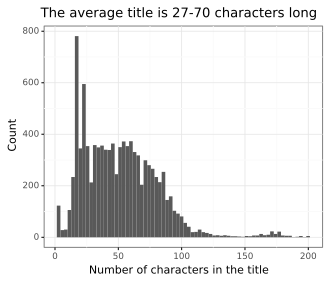

<ggplot: (8772116010003)>

In [25]:
g = (ggplot(plot_df, aes(x="title_length")) + 
     geom_histogram(bins=70) + 
     theme_bw() +
     theme(figure_size=(5, 4)) +
     ggtitle("The average title is 27-70 characters long") +
     xlab("Number of characters in the title") + 
     ylab("Count"))
g

## Content

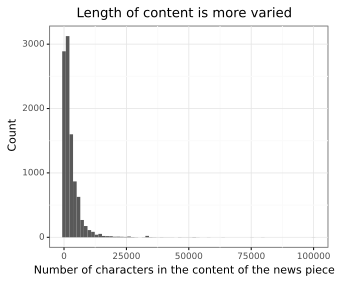

<ggplot: (8772103836799)>

In [26]:
g = (ggplot(plot_df, aes(x="content_length")) + 
     geom_histogram(bins=70) + 
     theme_bw() +
     theme(figure_size=(5, 4)) +
     ggtitle("Length of content is more varied") +
     xlab("Number of characters in the content of the news piece") + 
     ylab("Count"))
g

It helps to plot the x-axis on a log scale

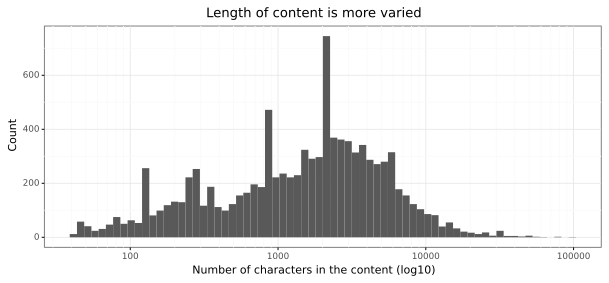

<ggplot: (8772115901663)>

In [27]:
g = (ggplot(plot_df, aes(x="content_length")) + 
     geom_histogram(bins=70) + 
     theme_bw() +
     theme(figure_size=(10, 4)) +
     ggtitle("Length of content is more varied") +
     scale_x_continuous(trans="log10", labels=lambda x: [int(xx) for xx in x]) +
     xlab("Number of characters in the content (log10)") + 
     ylab("Count"))
g

## Length of content per news type

/opt/conda/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


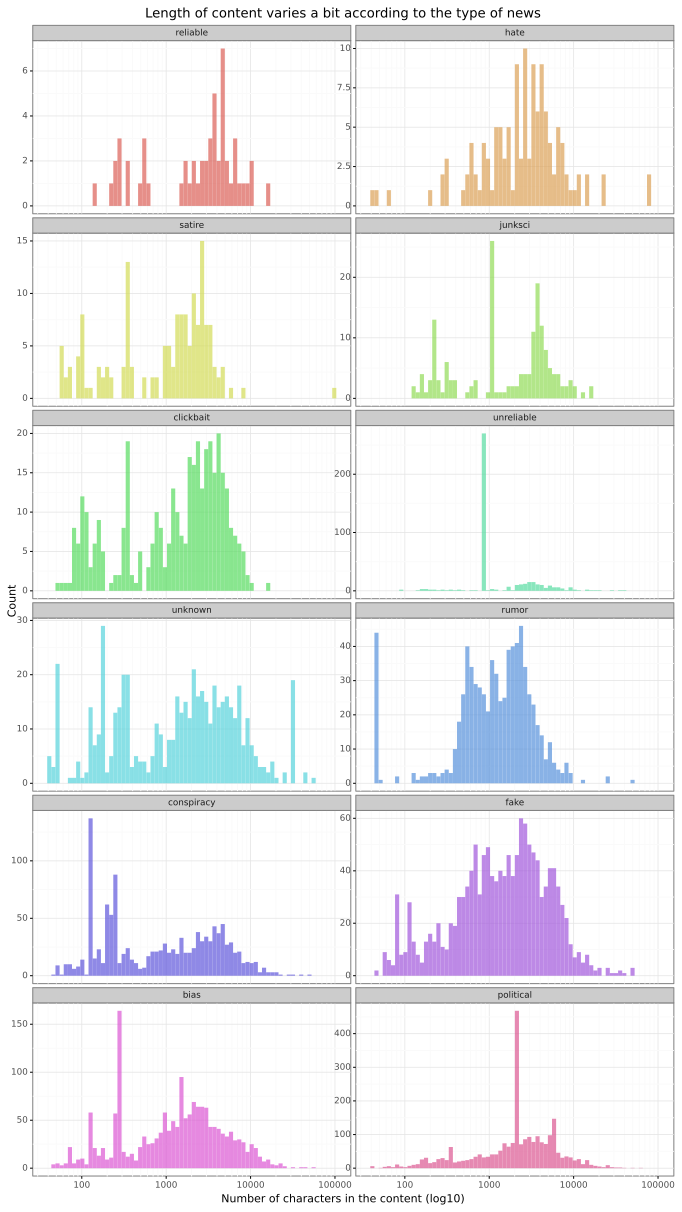

<ggplot: (8772116287112)>

In [28]:
g = (ggplot(plot_df[~plot_df["type"].isnull()], aes(x="content_length", fill="type")) + 
     geom_histogram(bins=70, alpha=0.7) + 
     theme_bw() +
     theme(figure_size=(5*2.2+0.5, 4*5+0.5)) +
     ggtitle("Length of content varies a bit according to the type of news") +
     scale_x_continuous(trans="log10", labels=lambda x: [int(xx) for xx in x]) +
     scale_fill_discrete(guide=False) +
     xlab("Number of characters in the content (log10)") + 
     ylab("Count") + 
     facet_wrap("~ type", ncol=2, scales="free_y"))
g

# Sentence embeddings

In [29]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("sentence-transformers/paraphrase-xlm-r-multilingual-v1", 
                            cache_folder="../results/")

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [30]:
embeddings = model.encode(sample_df["content"].astype(str).tolist(), show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Explore the similarity of the documents to find an "okay" threshold:

In [32]:
lower_bound = 0.62
upper_bound = 0.99

possible_ids = np.random.choice(range(sample_df.shape[0]), 1000)
possible_ids = [5305]
    
for selected_idx in tqdm.tqdm(possible_ids):

    cosine_scores = util.cos_sim([embeddings[selected_idx]], embeddings)
    top5 = cosine_scores.argsort(descending=True)[:,1:100].flatten().tolist()

    if any(cosine_scores[0][top5] > lower_bound) & any(cosine_scores[0][top5] < upper_bound):
        print_document(selected_idx)
        
        for pos, idx in enumerate(top5):
            if (cosine_scores[0][idx] > lower_bound) & (cosine_scores[0][idx] < upper_bound):
            
                print(f"<<SCORE>> {cosine_scores[0][idx]}")
                print(f"<<POS:>> {pos}")
                print_document(idx)

        break

  0%|          | 0/1 [00:00<?, ?it/s]

<<TITLE:>> PressTV-Yémen: un militaire saoudien tué à Asir
<<ID:>> 5305
<<SCRAPED_AT:>> 2017-11-27T01:15:02.476695
<<TYPE:>> bias
<<DOMAIN:>> presstv.com
----------------------------------------

<<START OF CONTENT>>

L’armée et les Comités populaires du Yémen ont lancé de grandes offensives à Salateh, région de la province de Najran, au sud de l'Arabie saoudite, le long de la frontière avec le Yémen.

Un certain nombre de militaires saoudiens ont été tués et blessés au cours de ces opérations.

Plusieurs véhicules militaires appartenant aux mercenaires ont été également détruits dans l’est de la province de Jawf par les forces yéménites.

D’autre part, les appareils de l’ennemi saoudien ont largué des bombes sur diverses zones résidentielles au Yémen.

L’artillerie de l’armée et des Comités populaires du Yémen ont pilonné dimanche un bastion des mercenaires saoudiens sur la colline d'as-Soda, au point de passage d’Alab situé à Asir.

Sur le même volet, un militaire saoudien a été élim

# Classification task: political vs bias

For this demonstration, let's focus on just two classes: political and bias.

Can ML algorithms differentiate documents from these two kind of sources?

In [37]:
df_pol_bias = sample_df[sample_df["type"].isin(["political", "conspiracy"])]
df_pol_bias["type"].value_counts()

political     2459
conspiracy    1233
reliable         0
hate             0
satire           0
junksci          0
clickbait        0
unreliable       0
unknown          0
rumor            0
fake             0
bias             0
Name: type, dtype: int64

In [38]:
X = embeddings[df_pol_bias.index,:]
y = df_pol_bias["type"].tolist()

# Train vs Test

Let us split into train and test:

In [39]:
from sklearn.model_selection import train_test_split, GridSearchCV

train_X, test_X, train_y, test_y = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state = 42)

## Algorithm: NaiveBayes

In [43]:
from sklearn.naive_bayes import MultinomialNB

# MultinomialNB().fit(train_X, train_y)

If you try to train it directly (with the code above), it will throw an error. This is because NaiveBayes only works with positive values and there are some embeddings with negative values.

Let's use a **MinMaxScaler** first to solve that:

In [41]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

train_pipeline = Pipeline(steps = [('minmax', MinMaxScaler()), ('mnnb', MultinomialNB())])

train_pipeline.fit(train_X, train_y)

Pipeline(steps=[('minmax', MinMaxScaler()), ('mnnb', MultinomialNB())])

Let's see how our model performs on the **held-out test set**:

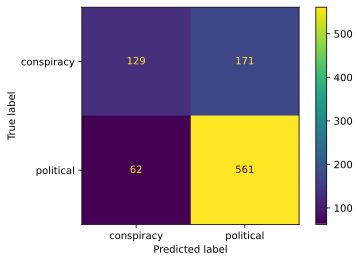

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred_y = train_pipeline.predict(test_X)

# Generate confusion matrix
cm = confusion_matrix(test_y, pred_y, labels=train_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_pipeline.classes_)
disp.plot()

**METRICS**

- **Precision:** Of the predicted positives for a particular class, how many were actually true?

$$\text{precision} = \frac{TP}{TP + FP}$$

- **Recall** (or sensitivity): of the actual positive classes for a particular class, how many did the classifier get right?

$$\text{recall} = \frac{TP}{P}$$

- **Accuracy:** how many did you get right?

$$\text{accuracy} = \frac{TP + TN}{P + N}$$

- **F1-score:** 

$$\text{F1-score} = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$

In [45]:
train_pipeline.classes_

array(['conspiracy', 'political'], dtype='<U10')

In [46]:
from sklearn.metrics import classification_report

print(classification_report(test_y, pred_y, labels=train_pipeline.classes_))

              precision    recall  f1-score   support

  conspiracy       0.68      0.43      0.53       300
   political       0.77      0.90      0.83       623

    accuracy                           0.75       923
   macro avg       0.72      0.67      0.68       923
weighted avg       0.74      0.75      0.73       923



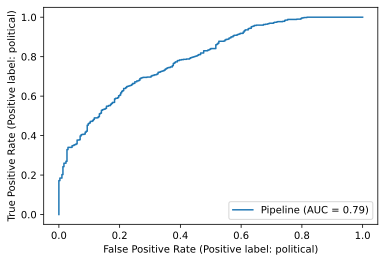

In [47]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(train_pipeline, test_X, test_y, pos_label="political")

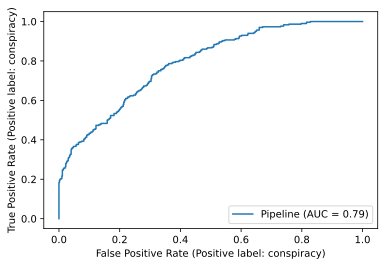

In [48]:
plot_roc_curve(train_pipeline, test_X, test_y, pos_label="conspiracy")

## Algorithm: Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

train_pipeline = Pipeline(steps = [("minmax", MinMaxScaler()), ('lr', LogisticRegression(max_iter=3000))])

train_pipeline.fit(train_X, train_y)

Pipeline(steps=[('minmax', MinMaxScaler()),
                ('lr', LogisticRegression(max_iter=3000))])

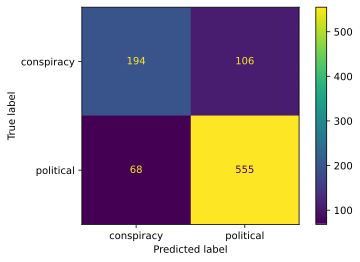

In [50]:
pred_y = train_pipeline.predict(test_X)

# Generate confusion matrix
cm = confusion_matrix(test_y, pred_y, labels=train_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_pipeline.classes_)
disp.plot()

In [51]:
print(classification_report(test_y, pred_y, labels=train_pipeline.classes_))

              precision    recall  f1-score   support

  conspiracy       0.74      0.65      0.69       300
   political       0.84      0.89      0.86       623

    accuracy                           0.81       923
   macro avg       0.79      0.77      0.78       923
weighted avg       0.81      0.81      0.81       923



## Algorithm: SVC

In [54]:
from sklearn.svm import SVC

train_pipeline = Pipeline(steps = [('svc', SVC())])

train_pipeline.fit(train_X, train_y)

Pipeline(steps=[('svc', SVC())])

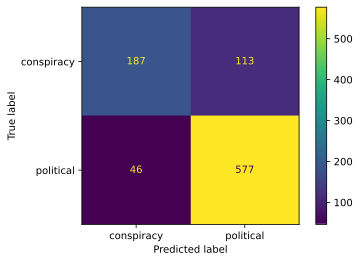

In [55]:
pred_y = train_pipeline.predict(test_X)

# Generate confusion matrix
cm = confusion_matrix(test_y, pred_y, labels=train_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_pipeline.classes_)
disp.plot()

In [56]:
print(classification_report(test_y, pred_y, labels=train_pipeline.classes_))

              precision    recall  f1-score   support

  conspiracy       0.80      0.62      0.70       300
   political       0.84      0.93      0.88       623

    accuracy                           0.83       923
   macro avg       0.82      0.77      0.79       923
weighted avg       0.83      0.83      0.82       923



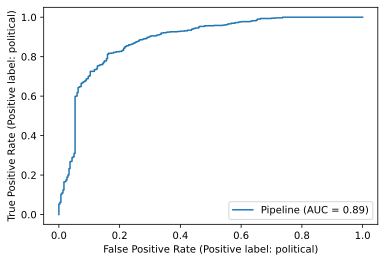

In [57]:
plot_roc_curve(train_pipeline, test_X, test_y, pos_label="political")

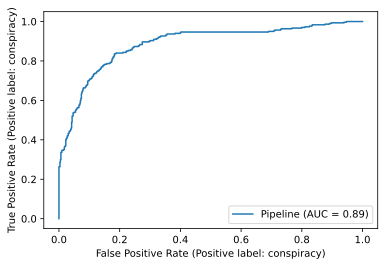

In [58]:
plot_roc_curve(train_pipeline, test_X, test_y, pos_label="conspiracy")

## Algorithm: Decision Tree

In [59]:
from sklearn.tree import DecisionTreeClassifier

train_pipeline = Pipeline(steps = [('dt', DecisionTreeClassifier())])

train_pipeline.fit(train_X, train_y)

Pipeline(steps=[('dt', DecisionTreeClassifier())])

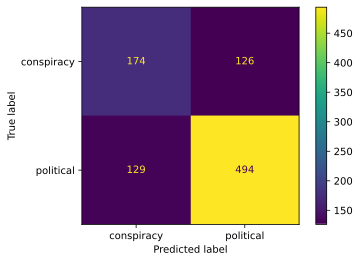

In [60]:
pred_y = train_pipeline.predict(test_X)

# Generate confusion matrix
cm = confusion_matrix(test_y, pred_y, labels=train_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_pipeline.classes_)
disp.plot()

In [61]:
print(classification_report(test_y, pred_y, labels=train_pipeline.classes_))

              precision    recall  f1-score   support

  conspiracy       0.57      0.58      0.58       300
   political       0.80      0.79      0.79       623

    accuracy                           0.72       923
   macro avg       0.69      0.69      0.69       923
weighted avg       0.72      0.72      0.72       923



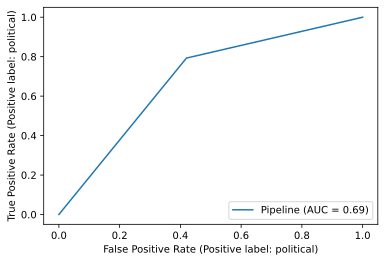

In [62]:
plot_roc_curve(train_pipeline, test_X, test_y, pos_label="political")

## Algorithm: Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier

train_pipeline = Pipeline(steps = [('rf', RandomForestClassifier())])

train_pipeline.fit(train_X, train_y)

Pipeline(steps=[('rf', RandomForestClassifier())])

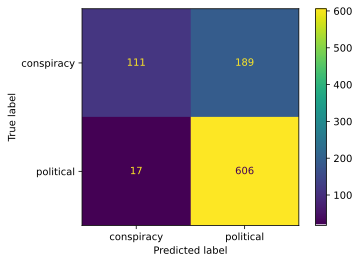

In [64]:
pred_y = train_pipeline.predict(test_X)

# Generate confusion matrix
cm = confusion_matrix(test_y, pred_y, labels=train_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_pipeline.classes_)
disp.plot()

In [65]:
print(classification_report(test_y, pred_y, labels=train_pipeline.classes_))

              precision    recall  f1-score   support

  conspiracy       0.87      0.37      0.52       300
   political       0.76      0.97      0.85       623

    accuracy                           0.78       923
   macro avg       0.81      0.67      0.69       923
weighted avg       0.80      0.78      0.75       923



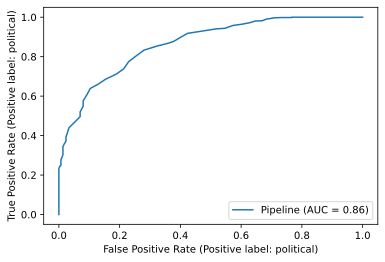

In [66]:
plot_roc_curve(train_pipeline, test_X, test_y, pos_label="political")

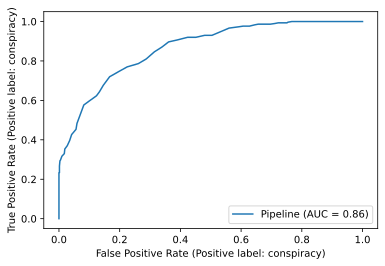

In [67]:
plot_roc_curve(train_pipeline, test_X, test_y, pos_label="conspiracy")

## Algorithm: GradientBoosting

In [68]:
from sklearn.ensemble import GradientBoostingClassifier

train_pipeline = Pipeline(steps = [('gboost', GradientBoostingClassifier())])

train_pipeline.fit(train_X, train_y)

Pipeline(steps=[('gboost', GradientBoostingClassifier())])

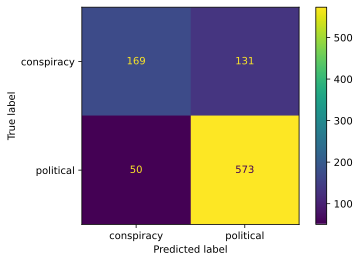

In [69]:
pred_y = train_pipeline.predict(test_X)

# Generate confusion matrix
cm = confusion_matrix(test_y, pred_y, labels=train_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_pipeline.classes_)
disp.plot()

In [70]:
print(classification_report(test_y, pred_y, labels=train_pipeline.classes_))

              precision    recall  f1-score   support

  conspiracy       0.77      0.56      0.65       300
   political       0.81      0.92      0.86       623

    accuracy                           0.80       923
   macro avg       0.79      0.74      0.76       923
weighted avg       0.80      0.80      0.79       923



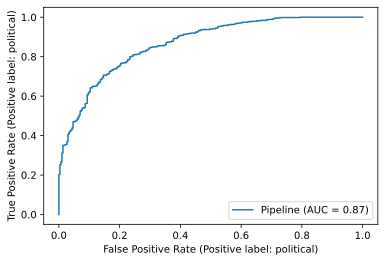

In [72]:
plot_roc_curve(train_pipeline, test_X, test_y, pos_label="political")

# Cross-Validation

If we don't do cross-validation, we will not know if our results were robust.

Link to [sklearn Cross-Validation page](https://scikit-learn.org/stable/modules/cross_validation.html) if you want to read more on the theory behind that.

## Algorithm: RandomForest

In [89]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')

scores = cross_validate(RandomForestClassifier(), 
                        train_X, train_y, 
                        scoring=f1, cv=5,
                        n_jobs=8)

In [84]:
scores.keys()

dict_keys(['fit_time', 'score_time', 'test_score'])

In [85]:
scores["test_score"]

array([0.66653899, 0.6649158 , 0.71325052, 0.68336633, 0.71687562])

In [87]:
scores["fit_time"]

array([3.53834033, 3.52254891, 3.48831964, 3.43450356, 3.44947076])

In [ ]:
scores["test_score"]

In [86]:
pd.Series(scores["test_score"]).describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
0,5.0,0.688989,0.024907,0.664916,0.666539,0.683366,0.713251,0.716876


## Algorithm: SVC

In [90]:
scores = cross_validate(SVC(), 
                        train_X, train_y, 
                        scoring=f1, cv=5,
                        n_jobs=8)

In [91]:
scores.keys()

dict_keys(['fit_time', 'score_time', 'test_score'])

In [92]:
scores["test_score"]

array([0.78345841, 0.83690121, 0.74882041, 0.78548512, 0.78944514])

In [93]:
scores["fit_time"]

array([1.38466287, 1.59792399, 1.46964574, 1.33710623, 1.38923836])

In [94]:
scores["test_score"]

array([0.78345841, 0.83690121, 0.74882041, 0.78548512, 0.78944514])

In [95]:
pd.Series(scores["test_score"]).describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
0,5.0,0.788822,0.031433,0.74882,0.783458,0.785485,0.789445,0.836901


**SVC is consistently better on the internal cross-validation** 

# Grid Search

Let us throw everything there and see what comes out. Is any method capable of improving the recall of the label `conspiracy`?

## Algorithm: RandomForest

**Setup and train**

In [96]:
from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')

train_pipeline = Pipeline(steps = [('rf', RandomForestClassifier())])

# Create Parameter Grid
pgrid = {
 'rf__class_weight' : ["balanced", "balanced_subsample"],
 'rf__max_depth'    : [1, 2, 3, 4, None]
}

# Apply GridSearch to Pipeline to find the best parameters
gs_rf = GridSearchCV(train_pipeline, pgrid, cv=10, n_jobs=12, verbose=2, scoring=f1)

# Fit the model
gs_rf.fit(train_X, train_y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             n_jobs=12,
             param_grid={'rf__class_weight': ['balanced', 'balanced_subsample'],
                         'rf__max_depth': [1, 2, 3, 4, None]},
             scoring=make_scorer(f1_score, average=macro), verbose=2)

**Investigate the results:**

Which combination of parameters have lead to the best outcomes?

In [97]:
cv_results = pd.DataFrame(gs_rf.cv_results_).sort_values(["rank_test_score"])
cv_results["params"] = cv_results["params"].apply(lambda x: " ".join(f"{key}:{val}" for key, val in x.items()))

cv_results.set_index(["rank_test_score", "params"])

,,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__class_weight,param_rf__max_depth,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,params,,,,,,,,,,,,,,,,,,
1,rf__class_weight:balanced rf__max_depth:4,2.049680,0.290651,0.019092,0.004624,balanced,4,0.767621,0.733955,0.777472,0.772273,0.744483,0.661294,0.730624,0.752906,0.765254,0.774510,0.748039,0.033010
2,rf__class_weight:balanced_subsample rf__max_depth:4,2.157436,0.320254,0.017110,0.003550,balanced_subsample,4,0.763140,0.724918,0.755084,0.749530,0.715206,0.677907,0.743565,0.778009,0.750675,0.752175,0.741021,0.026946
3,rf__class_weight:balanced_subsample rf__max_depth:3,1.745812,0.268233,0.017356,0.003365,balanced_subsample,3,0.746216,0.687823,0.775770,0.748340,0.700700,0.686622,0.711648,0.717367,0.724378,0.771056,0.726992,0.030555
4,rf__class_weight:balanced rf__max_depth:3,1.640503,0.241653,0.018061,0.004059,balanced,3,0.744483,0.703051,0.728579,0.737250,0.724222,0.660724,0.726824,0.698718,0.745366,0.754939,0.722416,0.026636
5,rf__class_weight:balanced_subsample rf__max_depth:2,1.285502,0.203557,0.017099,0.003673,balanced_subsample,2,0.710064,0.677791,0.713296,0.714371,0.679701,0.649034,0.687255,0.685920,0.719486,0.740364,0.697728,0.025111
6,rf__class_weight:balanced rf__max_depth:2,1.190574,0.182900,0.017394,0.003891,balanced,2,0.698529,0.691085,0.730850,0.734319,0.681672,0.619143,0.698593,0.667067,0.718857,0.709617,0.694973,0.032198
7,rf__class_weight:balanced rf__max_depth:None,4.522501,0.639418,0.022595,0.003957,balanced,None,0.639466,0.615566,0.708124,0.684904,0.688414,0.665079,0.681538,0.667517,0.651382,0.694494,0.669648,0.026493
8,rf__class_weight:balanced_subsample rf__max_depth:None,4.213770,0.422059,0.017350,0.000203,balanced_subsample,None,0.685043,0.602256,0.717387,0.646737,0.658654,0.685074,0.654563,0.641476,0.681696,0.719807,0.669269,0.034091
9,rf__class_weight:balanced_subsample rf__max_depth:1,0.790781,0.126513,0.016120,0.003104,balanced_subsample,1,0.687869,0.615116,0.658294,0.656889,0.661720,0.584643,0.655585,0.643491,0.675384,0.633938,0.647293,0.028423


**Now, predict the test samples with the best estimator**

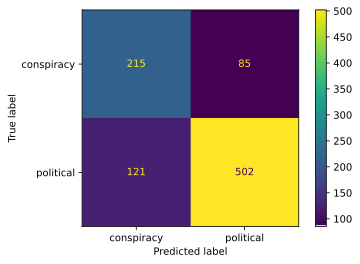

In [100]:
pred_y = gs_rf.predict(test_X)

# Generate confusion matrix
cm = confusion_matrix(test_y, pred_y, labels=gs_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs_rf.classes_)
disp.plot()

In [101]:
print(classification_report(test_y, pred_y, labels=gs_rf.classes_))

              precision    recall  f1-score   support

  conspiracy       0.64      0.72      0.68       300
   political       0.86      0.81      0.83       623

    accuracy                           0.78       923
   macro avg       0.75      0.76      0.75       923
weighted avg       0.79      0.78      0.78       923



### Algorithm: SVC

In [98]:
train_pipeline = Pipeline(steps = [('svc', SVC())])

# Create Parameter Grid
pgrid = {
 'svc__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
 'svc__decision_function_shape' : ['ovo', 'ovr'],
 'svc__C' : [1.0, 0.9, 0.8, 0.7]
}

# Apply GridSearch to Pipeline to find the best parameters
gs_svc = GridSearchCV(train_pipeline, pgrid, cv=10, n_jobs=12, verbose=2, scoring=f1)

# Fit the model
gs_svc.fit(train_X, train_y)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


GridSearchCV(cv=10, estimator=Pipeline(steps=[('svc', SVC())]), n_jobs=12,
             param_grid={'svc__C': [1.0, 0.9, 0.8, 0.7],
                         'svc__decision_function_shape': ['ovo', 'ovr'],
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring=make_scorer(f1_score, average=macro), verbose=2)

**Investigate the results**

In [99]:
cv_results = pd.DataFrame(gs_svc.cv_results_).sort_values(["rank_test_score"])
cv_results["params"] = cv_results["params"].apply(lambda x: " ".join(f"{key}:{val}" for key, val in x.items()))

cv_results.set_index(["rank_test_score", "params"])

mean_fit_time  \
rank_test_score params                                                              
1               svc__C:1.0 svc__decision_function_shape:ovo svc...       3.185196   
                svc__C:1.0 svc__decision_function_shape:ovr svc...       2.863693   
3               svc__C:0.9 svc__decision_function_shape:ovr svc...       3.084966   
                svc__C:0.9 svc__decision_function_shape:ovo svc...       2.953512   
5               svc__C:0.8 svc__decision_function_shape:ovr svc...       3.360136   
                svc__C:0.8 svc__decision_function_shape:ovo svc...       3.327180   
7               svc__C:0.7 svc__decision_function_shape:ovo svc...       3.317546   
                svc__C:0.7 svc__decision_function_shape:ovr svc...       3.409894   
9               svc__C:0.8 svc__decision_function_shape:ovr svc...       3.709593   
                svc__C:0.8 svc__decision_function_shape:ovo svc...       3.477605   
11              svc__C:0.9 svc__decision_function_shape:ovr svc...       3.900250   
                svc__C:0.9 svc__decision_function_shape:ovo svc...       3.646318   
13              svc__C:0.7 svc__decision_function_shape:ovo svc...       2.932900   
                svc__C:0.7 svc__decision_function_shape:ovr svc...       3.731966   
15              svc__C:1.0 svc__decision_function_shape:ovr svc...       3.666271   
                svc__C:1.0 svc__decision_function_shape:ovo svc...       3.986782   
17              svc__C:1.0 svc__decision_function_shape:ovr svc...       4.108124   
                svc__C:1.0 svc__decision_function_shape:ovo svc...       3.837227   
19              svc__C:0.9 svc__decision_function_shape:ovr svc...       3.490638   
                svc__C:0.9 svc__decision_function_shape:ovo svc...       3.666214   
21              svc__C:0.8 svc__decision_function_shape:ovo svc...       3.634167   
                svc__C:0.8 svc__decision_function_shape:ovr svc...       3.327968   
23              svc__C:0.8 svc__decision_function_shape:ovr svc...       2.727426   
                svc__C:0.8 svc__decision_function_shape:ovo svc...       2.704517   
25              svc__C:0.7 svc__decision_function_shape:ovo svc...       3.118730   
                svc__C:0.7 svc__decision_function_shape:ovr svc...       2.085675   
27              svc__C:0.9 svc__decision_function_shape:ovo svc...       3.044380   
                svc__C:0.9 svc__decision_function_shape:ovr svc...       2.862146   
29              svc__C:1.0 svc__decision_function_shape:ovr svc...       2.915286   
                svc__C:1.0 svc__decision_function_shape:ovo svc...       2.875754   
31              svc__C:0.7 svc__decision_function_shape:ovr svc...       2.945658   
                svc__C:0.7 svc__decision_function_shape:ovo svc...       3.682594   

                                                                    std_fit_time  \
rank_test_score params                                                             
1               svc__C:1.0 svc__decision_function_shape:ovo svc...      1.128734   
                svc__C:1.0 svc__decision_function_shape:ovr svc...      0.984512   
3               svc__C:0.9 svc__decision_function_shape:ovr svc...      0.977559   
                svc__C:0.9 svc__decision_function_shape:ovo svc...      1.008362   
5               svc__C:0.8 svc__decision_function_shape:ovr svc...      1.035845   
                svc__C:0.8 svc__decision_function_shape:ovo svc...      1.022728   
7               svc__C:0.7 svc__decision_function_shape:ovo svc...      1.094912   
                svc__C:0.7 svc__decision_function_shape:ovr svc...      1.183362   
9               svc__C:0.8 svc__decision_function_shape:ovr svc...      1.101395   
                svc__C:0.8 svc__decision_function_shape:ovo svc...      1.179527   
11              svc__C:0.9 svc__decision_function_shape:ovr svc...      1.151791   
                svc__C:0.9 svc__decision_function_shape:ovo svc...      1.183768   
1

**Now, predict the test samples with the best estimator**

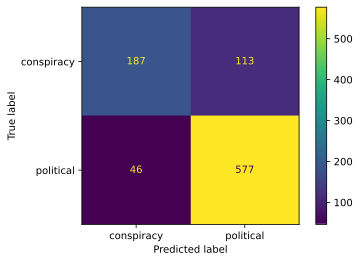

In [102]:
pred_y = gs_svc.predict(test_X)

# Generate confusion matrix
cm = confusion_matrix(test_y, pred_y, labels=gs_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs_rf.classes_)
disp.plot()

In [103]:
print(classification_report(test_y, pred_y, labels=gs_svc.classes_))

              precision    recall  f1-score   support

  conspiracy       0.80      0.62      0.70       300
   political       0.84      0.93      0.88       623

    accuracy                           0.83       923
   macro avg       0.82      0.77      0.79       923
weighted avg       0.83      0.83      0.82       923



# Crazy Idea: Stacking

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

estimators = [
    ('rf', RandomForestClassifier(class_weight="balanced", max_depth = 4)),
    ('svc', SVC(C=1.0, kernel="rbf"))
]
train_pipeline = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

train_pipeline.fit(train_X, train_y)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=4)),
                               ('svc', SVC())],
                   final_estimator=LogisticRegression())

**How is the prediction now?**

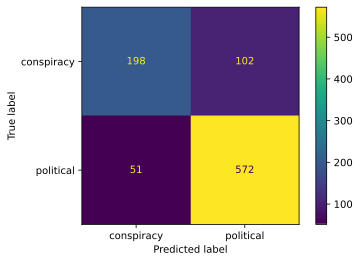

In [109]:
pred_y = train_pipeline.predict(test_X)

# Generate confusion matrix
cm = confusion_matrix(test_y, pred_y, labels=train_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_pipeline.classes_)
disp.plot()

In [110]:
print(classification_report(test_y, pred_y, labels=train_pipeline.classes_))

              precision    recall  f1-score   support

  conspiracy       0.80      0.66      0.72       300
   political       0.85      0.92      0.88       623

    accuracy                           0.83       923
   macro avg       0.82      0.79      0.80       923
weighted avg       0.83      0.83      0.83       923



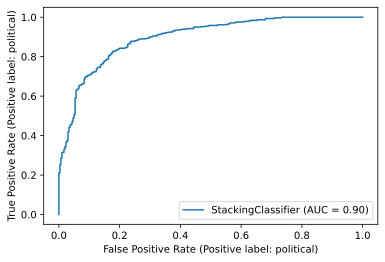

In [111]:
plot_roc_curve(train_pipeline, test_X, test_y, pos_label="political")

# Full training

(To help us debug the model)

In [112]:
train_pipeline = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

train_pipeline.fit(X, y)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=4)),
                               ('svc', SVC())],
                   final_estimator=LogisticRegression())

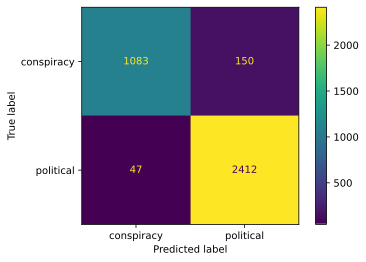

In [113]:
pred_y = train_pipeline.predict(X)

# Generate confusion matrix
cm = confusion_matrix(y, pred_y, labels=train_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_pipeline.classes_)
disp.plot()

In [114]:
print(classification_report(y, pred_y, labels=train_pipeline.classes_))

              precision    recall  f1-score   support

  conspiracy       0.96      0.88      0.92      1233
   political       0.94      0.98      0.96      2459

    accuracy                           0.95      3692
   macro avg       0.95      0.93      0.94      3692
weighted avg       0.95      0.95      0.95      3692



## Which ones get misclassified?

In [122]:
misclassified = np.where(y != pred_y)[0]

### True = conspiracy & Prediction = political

In [139]:
misclassified1 = np.argwhere((np.array(y) == "conspiracy") & (np.array(pred_y) == "political")).flatten()
misclassified1

array([  65,   88,  107,  118,  121,  135,  179,  249,  267,  271,  283,
        301,  330,  363,  369,  375,  395,  400,  496,  525,  546,  605,
        606,  655,  677,  688,  689,  731,  733,  740,  743,  764,  791,
        808,  820,  828,  860,  880,  882,  895,  930,  933,  939,  982,
       1020, 1038, 1048, 1061, 1104, 1107, 1129, 1170, 1190, 1205, 1214,
       1263, 1319, 1359, 1378, 1401, 1472, 1503, 1532, 1540, 1601, 1637,
       1703, 1795, 1838, 1856, 1861, 1896, 1939, 1974, 2007, 2012, 2016,
       2048, 2056, 2078, 2084, 2086, 2112, 2146, 2173, 2196, 2217, 2251,
       2272, 2275, 2301, 2311, 2314, 2326, 2332, 2347, 2380, 2525, 2553,
       2591, 2647, 2696, 2753, 2755, 2756, 2761, 2773, 2831, 2861, 2865,
       2868, 2887, 2933, 2952, 2971, 2979, 2982, 3008, 3016, 3037, 3044,
       3088, 3127, 3147, 3156, 3177, 3213, 3246, 3260, 3266, 3360, 3369,
       3395, 3419, 3427, 3490, 3498, 3499, 3505, 3560, 3563, 3582, 3584,
       3591, 3617, 3647, 3651, 3653, 3666, 3689])

In [144]:
df_pol_bias.iloc[misclassified1]["domain"].value_counts(dropna=False)

fellowshipoftheminds.com          17
abovetopsecret.com                15
thedailysheeple.com               13
zerohedge.com                     12
newstarget.com                    11
conservativerefocus.com           10
activistpost.com                   9
freedomoutpost.com                 7
canadafreepress.com                7
americanfreepress.net              6
familysecuritymatters.org          4
truthbroadcastnetwork.com          4
jihadwatch.org                     4
infowars.com                       4
rense.com                          3
dcclothesline.com                  3
pamelageller.com                   3
21stcenturywire.com                3
endoftheamericandream.com          2
thelibertybeacon.com               1
investmentresearchdynamics.com     1
thephaser.com                      1
eyeopening.info                    1
theeconomiccollapseblog.com        1
prisonplanet.com                   1
infiniteunknown.net                1
intellihub.com                     1
t

In [147]:
df_pol_bias.iloc[misclassified1].query("domain == 'fellowshipoftheminds.com'").index

Int64Index([1711, 2410, 2715, 2830, 3172, 3258, 3703, 3883, 4321, 6263, 6294,
            7793, 8531, 8863, 9131, 9292, 9894],
           dtype='int64')

In [156]:
def print_similar_docs(possible_ids, lower_bound=0, upper_bound=0.99):
    for selected_idx in tqdm.tqdm(possible_ids):

        cosine_scores = util.cos_sim([embeddings[selected_idx]], embeddings)
        top5 = cosine_scores.argsort(descending=True)[:,1:100].flatten().tolist()

        if any(cosine_scores[0][top5] > lower_bound) & any(cosine_scores[0][top5] < upper_bound):
            print_document(selected_idx)

            for pos, idx in enumerate(top5):
                if (cosine_scores[0][idx] > lower_bound) & (cosine_scores[0][idx] < upper_bound):

                    print(f"<<SCORE>> {cosine_scores[0][idx]}")
                    print(f"<<POS:>> {pos}")
                    print_document(idx)

In [158]:
# print_similar_docs([1711])

### True = political & Prediction == conspiracy

In [159]:
misclassified2 = np.argwhere((np.array(y) == "political") & (np.array(pred_y) == "conspiracy")).flatten()

In [145]:
df_pol_bias.iloc[misclassified2]["domain"].value_counts(dropna=False)

dailykos.com              17
rinf.com                   7
mintpressnews.com          3
chroniclesmagazine.org     3
pjmedia.com                2
rawstory.com               2
jackpineradicals.com       2
dailycaller.com            2
guardianlv.com             1
alternet.org               1
resistancereport.com       1
thefifthcolumnnews.com     1
dennismichaellynch.com     1
dissentmagazine.org        1
nakedcapitalism.com        1
breitbart.com              1
countercurrents.org        1
Name: domain, dtype: int64

In [160]:
df_pol_bias.iloc[misclassified2].query("domain == 'dailykos.com'").index

Int64Index([ 558, 1347, 1944, 3344, 3396, 4520, 4749, 5734, 6417, 6494, 6546,
            7036, 8145, 8328, 8538, 9025, 9163],
           dtype='int64')

In [162]:
# print_similar_docs([558])

# Clusters with the sentence-transformers library

I will link two documents if they have a similarity of $t_\alpha \ge 0.56$.

In [262]:
membership = util.community_detection(X, threshold=0.56)

In [316]:
df_comm = pd.Series(membership, name="doc_ids").to_frame()
df_comm["size"] = df_comm["doc_ids"].apply(lambda x: len(x))
df_comm["comm_id"] = ["c%02d" % i for i in range(df_comm.shape[0])]

def elect_representative_document(cluster_members, X=X):
    avg_embedding = X[cluster_members].mean(axis=0)
    rep_id = util.semantic_search(avg_embedding, X, top_k=1)[0][0]["corpus_id"]
    return pd.Series({"rep_id": int(rep_id),
                      "rep_title": df_pol_bias.iloc[rep_id]["title"]})

df_comm = pd.concat([df_comm, 
                     df_comm["doc_ids"].apply(elect_representative_document)], axis=1)
df_comm["rep_id"] = df_comm["rep_id"].astype(int)

# df_comm.sort_values(["size"], ascending=True, inplace=True)
df_comm.set_index(["rep_title"])

,doc_ids,size,comm_id,rep_id
rep_title,,,,
Iran News Round Up,"[2392, 3422, 3060, 674, 2738, 3425, 1062, 365,...",398,c00,14
NaN,"[219, 1982, 2477, 3158, 2018, 3181, 3190, 2819...",127,c01,15
Chairman of the Senate Banking Committee,"[780, 1840, 3300, 1081, 570, 1184, 1183, 2776,...",67,c02,116
Video-Bush Triggers Premature Confetti Attack,"[2783, 27, 321, 2307, 2845, 801, 3343, 3375, 2...",46,c03,27
Search by property,"[63, 1273, 867, 372, 3400, 105, 620, 869, 893,...",33,c04,893
Marcia S. Krieger,"[45, 328, 3571, 3429, 1429, 2636, 3052, 2719, ...",29,c05,2931
If I Were David Axelrod,"[2041, 1518, 3626, 151, 2273, 2082, 1150, 3044...",20,c06,2041
MAJOR UPDATE: WHIP These Democrats Into Supporting The Health Bill!,"[823, 281, 2218, 2265, 1528, 505, 835, 2696, 2...",13,c07,823
‘Looks impressive only on TV’: US fight against ISIS criticized for spreading terror further afield,"[2841, 502, 3136, 225, 2745, 3239, 901, 2154, ...",13,c08,2841


## How many documents are clustered?

In [284]:
import itertools

all_clustered = list(itertools.chain.from_iterable(df_comm["doc_ids"]))

print(f"Pctg of clustered documents: {100 * len(all_clustered)/df_pol_bias.shape[0]:.2f} % ")

Pctg of clustered documents: 21.61 % 


In [320]:
print_document(116, df_pol_bias)

<<TITLE:>> Chairman of the Senate Banking Committee
<<ID:>> 116
<<SCRAPED_AT:>> 2018-01-25 20:13:50.426130
<<TYPE:>> conspiracy
<<DOMAIN:>> wikispooks.com
----------------------------------------

<<START OF CONTENT>>

"Query depth" is a predefined property that informs about the depth (numerical value computed on the basis of subquery nesting and resolved property chains) of a query while query execution is being restricted by the $smwgQMaxDepth setting.




<<END OF CONTENT>>

----------------------------------------


In [317]:
cluster_id = 2

cluster_members = df_comm["doc_ids"].iloc[cluster_id]
df_pol_bias.iloc[cluster_members]["title"].value_counts(dropna=False)

Hassan Rouhani                          2
2011 England riots                      1
Paul Joseph Watson                      1
Pan Am Flight 103                       1
Hans-Lothar Domröse                     1
                                       ..
Rene Pleven                             1
Free market                             1
Violent extremism                       1
Shadow Secretary of State for Health    1
Property:Has namebase                   1
Name: title, Length: 66, dtype: int64

In [299]:


# pd.crosstab(sample_df.iloc[cluster_members]["type"],
#             sample_df.iloc[cluster_members]["domain"])

# # sample_df.iloc[cluster_members].sample(n=10).set_index(["title"])[[]]

# avg_embedding = embeddings[cluster_members].mean(axis=0)
# rep_id = util.semantic_search(avg_embedding, embeddings, top_k=1)[0][0]["corpus_id"]

# print_document(rep_id)

# Network analysis

In [163]:
cosine_scores = util.cos_sim(X, X)

<AxesSubplot:>

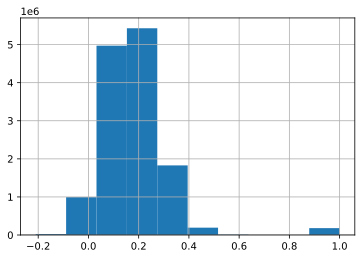

In [164]:
pd.Series(cosine_scores.flatten().numpy()).hist()

In [308]:
import torch

m = torch.nn.Threshold(0.52, 0)
adj_matrix = m(cosine_scores).fill_diagonal_(0).numpy()
adj_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [321]:
import networkx as nx
G = nx.from_numpy_array(adj_matrix, create_using=nx.Graph, parallel_edges=False)

In [322]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3692
Number of edges: 94087
Average degree:  50.9680


In [323]:
nx.density(G)

0.013808734490178887

In [324]:
nx.set_node_attributes(G, name="Label", values={n:n for n in G.nodes()})
nx.set_node_attributes(G, name="title", values={n:df_pol_bias.iloc[n]["title"] for n in G.nodes()})

In [325]:
G.nodes[116]

{'Label': 116, 'title': 'Chairman of the Senate Banking Committee'}

In [326]:
degrees = nx.degree(G)

df_degrees = pd.Series([degrees[n] for n in G.nodes()], name="degree").to_frame()
df_degrees.index.name = "node"

df_degrees

,degree
node,
0,1
1,2
2,1
3,1
4,0
...,...
3687,1
3688,0
3689,0


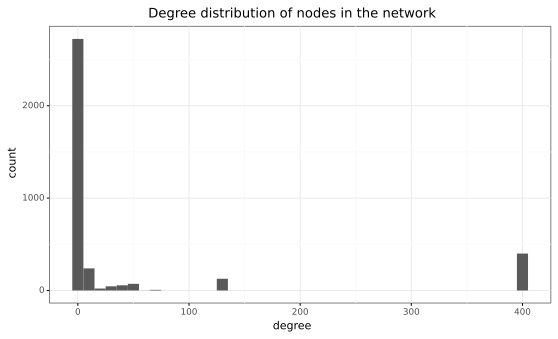

<ggplot: (8771952319377)>

In [327]:
g = (ggplot(df_degrees, aes(x="degree")) + 
     geom_histogram(binwidth=10) + 
     theme_bw() + 
     theme(figure_size=(9, 5)) +
     # scale_x_continuous(trans="log10") +
     ggtitle("Degree distribution of nodes in the network"))
g

## Connected components

In [328]:
components = list(nx.connected_components(G))

np.array([len(comp) for comp in components])

array([1272,    3,    2, ...,    1,    1,    1])

Number of represented elements:

In [329]:
sum([len(comp) for comp in components])

3692

**How many disconnected components are there?**

In [330]:
print(f"Pctg of unclustered documents:",
      f"{100 * sum([len(comp) == 1 for comp in components])/df_pol_bias.shape[0]:.2f} % ")

Pctg of unclustered documents: 45.02 % 


In [331]:
arr_order = list(reversed(np.array([len(comp) for comp in components]).argsort()))
pd.Series([len(comp) for comp in components])[arr_order]

0       1272
11       127
14       107
17        46
26        29
        ... 
1208       1
1209       1
1210       1
1211       1
903        1
Length: 1808, dtype: int64

In [332]:
giant_component = G.subgraph(components[0])
print(nx.info(giant_component))

Name: 
Type: Graph
Number of nodes: 1272
Number of edges: 81537
Average degree: 128.2028


In [333]:
nx.density(giant_component)

0.10086768700918902

**Export to visualize:**

In [334]:
nx.write_gml(giant_component, "../results/news_giant_component.gml")